In [1]:
import pandas as pd
import time
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import xgboost
import category_encoders
import warnings
from itertools import product
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
train_sales = pd.read_csv('sales_train.csv')
train_sales.shape

(2935849, 6)

In [3]:
train_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
def dtype(df):
    cols = [i for i in df.columns if df[i].dtype == 'int64']
    df[cols] = df[cols].astype(np.int8)
    return df

In [5]:
a = train_sales['date']

In [6]:
gr = train_sales.groupby('date_block_num')['item_cnt_day'].sum()

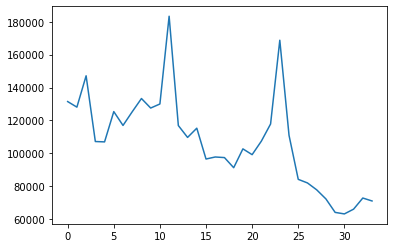

In [7]:
plt.plot(gr.index, gr.values)

In [9]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
test = pd.read_csv('test.csv')
test.shape

(214200, 3)

In [11]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
items = pd.read_csv('items.csv')

In [13]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
item_cat = pd.read_csv('item_categories.csv')

In [15]:
print(item_cat.shape)
item_cat.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
shops = pd.read_csv('shops.csv')

In [17]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [18]:
shops.loc[[0, 1], 'shop_name'] = shops.loc[[0, 1], 'shop_name'].apply(lambda x: x[1:])

In [19]:
shops['city'] = pd.factorize(shops['shop_name'].apply(lambda x: x.split()[0]))[0]
shops = shops[['city', 'shop_id']]

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

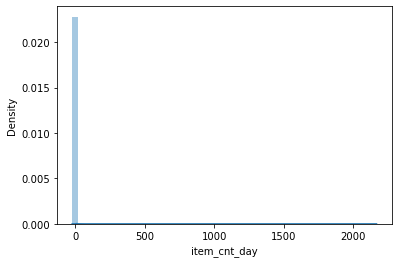

In [20]:
sns.distplot(train_sales['item_cnt_day'])

<AxesSubplot:xlabel='item_cnt_day'>

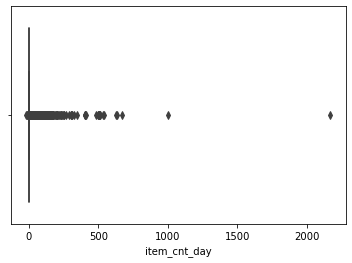

In [21]:
sns.boxplot(train_sales['item_cnt_day'])

<AxesSubplot:xlabel='item_price'>

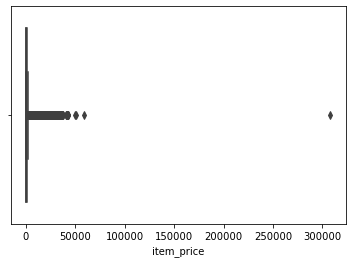

In [22]:
sns.boxplot(train_sales['item_price'])

In [23]:
train_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [24]:
train_sales[train_sales['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [25]:
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


In [26]:
items[items['item_id'] == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [27]:
train_sales[train_sales['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [28]:
train_sales.drop(train_sales[train_sales['item_cnt_day'] > 1010].index, inplace=True)

In [29]:
train_sales[train_sales['item_price'] > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [30]:
items[items['item_id'] == 6066]['item_name']

6066    Radmin 3  - 522 лиц.
Name: item_name, dtype: object

In [31]:
train_sales.drop(train_sales[(train_sales['item_price'] > 100000) & (train_sales['item_price'] < 0)].index, inplace=True)

In [32]:
train_sales.loc[train_sales.shop_id == 0, 'shop_id'] = 57
train_sales.loc[train_sales.shop_id == 1, 'shop_id'] = 58
train_sales.loc[train_sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [33]:
train = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train_sales[train_sales.date_block_num==i]
    train.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [34]:
train = pd.DataFrame(np.vstack(train), columns=cols)

In [35]:
print(train.shape)
train.head()

(10913850, 3)


,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [36]:
train_sales['sum'] = train_sales['item_cnt_day'] * train_sales['item_price']

In [37]:
group = train_sales.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day', 'sum']].sum().reset_index()

In [38]:
trains_ind = train.shape[0]

In [39]:
test.insert(0, 'date_block_num', 34)

In [40]:
test_id = test['ID']
test.drop('ID', 1, inplace=True)

In [41]:
train_test = pd.concat([train, test])
del train, test
gc.collect()

109

In [42]:
train_test = train_test.merge(group, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [43]:
train_test = train_test.merge(items.drop('item_name', 1), on='item_id', how='left')

In [44]:
train_test = train_test.merge(shops, on='shop_id', how='left')

In [45]:
train_test

,date_block_num,shop_id,item_id,item_cnt_day,sum,item_category_id,city
0,0,59,22154,1.0,999.0,37,30
1,0,59,2552,NaN,NaN,58,30
2,0,59,2554,NaN,NaN,58,30
3,0,59,2555,NaN,NaN,56,30
4,0,59,2564,NaN,NaN,59,30
...,...,...,...,...,...,...,...
11128045,34,45,18454,NaN,NaN,55,21
11128046,34,45,16188,NaN,NaN,64,21
11128047,34,45,15757,NaN,NaN,55,21
11128048,34,45,19648,NaN,NaN,40,21


In [46]:
item_cat['name_cat'] = item_cat['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
item_cat['name_cat'] = pd.factorize(item_cat['name_cat'])[0]
item_cat['name_cat2'] = pd.factorize(item_cat['item_category_name'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()))[0]
item_cat = item_cat[['item_category_id', 'name_cat', 'name_cat2']]
train_test = train_test.merge(item_cat, on='item_category_id', how='left')

In [47]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_day,sum,item_category_id,city,name_cat,name_cat2
0,0,59,22154,1.0,999.0,37,30,11,2
1,0,59,2552,NaN,NaN,58,30,13,7
2,0,59,2554,NaN,NaN,58,30,13,7
3,0,59,2555,NaN,NaN,56,30,13,7
4,0,59,2564,NaN,NaN,59,30,13,7


In [48]:
train_test['month'] = train_test['date_block_num'] % 12

In [49]:
train_test.isna().mean()

date_block_num      0.000000
shop_id             0.000000
item_id             0.000000
item_cnt_day        0.855399
sum                 0.855399
item_category_id    0.000000
city                0.000000
name_cat            0.000000
name_cat2           0.000000
month               0.000000
dtype: float64

In [50]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_day      float64
 4   sum               float64
 5   item_category_id  int64  
 6   city              int64  
 7   name_cat          int64  
 8   name_cat2         int64  
 9   month             int64  
dtypes: float64(2), int64(8)
memory usage: 933.9 MB


In [51]:
def f(df, lags, col):
    df1 = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        cop = df1.copy()
        cop.columns = ['date_block_num','shop_id','item_id', col+ '_'+str(i)]
        cop['date_block_num'] += i
        df = pd.merge(df, cop, on=['date_block_num','shop_id','item_id'], how='left')
    return df

train_test['item_cnt_day'] = train_test['item_cnt_day'].fillna(0).clip(0, 20)
train_test['sum'] = train_test['sum'].fillna(0)
merge = [(['item_id', 'shop_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12]),
        (['shop_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12]),
        (['item_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12]),
        (['shop_id', 'item_category_id', 'date_block_num'], 'item_cnt_day', [1]),
        (['name_cat', 'date_block_num'], 'item_cnt_day', [1]),
        (['date_block_num', 'name_cat2'], 'item_cnt_day', [1])]
cols = []
for i in merge:
    group = train_test.groupby(i[0]).agg({i[1]: 'mean'})
    name_col = '_'.join(i[0]) + '_' + i[1]
    group.columns = [name_col]
    group.reset_index(inplace=True)
    train_test = train_test.merge(group, on=i[0], how='left')
    train_test = f(train_test, i[2], name_col)
    train_test.drop(name_col, 1, inplace=True)
price = train_sales.groupby('item_id')['item_price'].mean()
price_date = train_sales.groupby(['item_id', 'date_block_num'])['item_price'].mean().reset_index()
price_date.columns = ['item_id', 'date_block_num', 'item_price_date']
train_test = train_test.merge(price_date, on=['item_id', 'date_block_num'], how='left')
train_test = f(train_test, [1], 'item_price_date')
train_test.drop('item_price_date', 1, inplace=True)
summ = train_sales.groupby(['shop_id'])['sum'].mean().reset_index()
summ.columns = ['shop_id', 'sum_shop']
train_test = train_test.merge(summ, on=['shop_id'], how='left')
summ_date = train_sales.groupby(['shop_id', 'date_block_num'])['sum'].sum().reset_index()
summ_date.columns = ['date_block_num', 'shop_id', 'sum_date_shop']
train_test = train_test.merge(summ_date, on=['date_block_num', 'shop_id'], how='left')
train_test['sum_diff'] = (train_test['sum_date_shop'] - train_test['sum_shop']) / train_test['sum_shop']
train_test = f(train_test, [1], 'sum_diff')
train_test.drop(['sum_shop', 'sum_date_shop', 'sum_diff'], axis=1, inplace=True)
train_test = train_test.merge(price, on='item_id', how='left')
train_test['price_diff'] = (train_test['item_price_date_1'] - train_test['item_price']) / train_test['item_price']
train_test.drop('sum', 1, inplace=True)
train_test.drop('item_price', 1, inplace=True)

In [52]:
train_test = dtype(train_test)

In [53]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,city,name_cat,name_cat2,month,item_id_shop_id_date_block_num_item_cnt_day_1,...,item_id_date_block_num_item_cnt_day_4,item_id_date_block_num_item_cnt_day_5,item_id_date_block_num_item_cnt_day_6,item_id_date_block_num_item_cnt_day_12,shop_id_item_category_id_date_block_num_item_cnt_day_1,name_cat_date_block_num_item_cnt_day_1,date_block_num_name_cat2_item_cnt_day_1,item_price_date_1,sum_diff_1,price_diff
0,0,59,-118,1.0,37,30,11,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,-8,0.0,58,30,13,7,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,-6,0.0,58,30,13,7,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,-5,0.0,56,30,13,7,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,4,0.0,59,30,13,7,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
train_test = train_test.fillna(0)

In [55]:
train = train_test.iloc[:trains_ind]
test = train_test.iloc[trains_ind:]

In [56]:
train.drop(train[train.date_block_num < 12].index, inplace=True)

In [57]:
del train_test
gc.collect()

194

In [58]:
test.drop('item_cnt_day', 1, inplace=True)

In [59]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,city,name_cat,name_cat2,month,item_id_shop_id_date_block_num_item_cnt_day_1,...,item_id_date_block_num_item_cnt_day_4,item_id_date_block_num_item_cnt_day_5,item_id_date_block_num_item_cnt_day_6,item_id_date_block_num_item_cnt_day_12,shop_id_item_category_id_date_block_num_item_cnt_day_1,name_cat_date_block_num_item_cnt_day_1,date_block_num_name_cat2_item_cnt_day_1,item_price_date_1,sum_diff_1,price_diff
4488756,12,54,57,4.0,37,27,11,2,0,3.0,...,0.000000,0.000000,0.000000,0.0,0.585946,0.269904,0.270218,741.560714,0.0,0.037453
4488757,12,54,56,3.0,38,27,11,2,0,0.0,...,0.000000,0.000000,0.000000,0.0,0.551913,0.269904,0.270218,1599.000000,0.0,0.084995
4488758,12,54,58,14.0,40,27,11,2,0,20.0,...,0.000000,0.000000,0.000000,0.0,0.822974,0.269904,0.270218,392.347518,0.0,0.438594
4488759,12,54,60,3.0,37,27,11,2,0,1.0,...,0.000000,0.000000,0.000000,0.0,0.585946,0.269904,0.270218,682.033333,0.0,0.160869
4488760,12,54,44,1.0,57,27,13,7,0,0.0,...,0.066667,0.222222,0.195652,0.0,0.455357,0.217979,0.217979,266.000000,0.0,-0.073800


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6425094 entries, 4488756 to 10913849
Data columns (total 36 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   date_block_num                                          int8   
 1   shop_id                                                 int8   
 2   item_id                                                 int8   
 3   item_cnt_day                                            float64
 4   item_category_id                                        int8   
 5   city                                                    int8   
 6   name_cat                                                int8   
 7   name_cat2                                               int8   
 8   month                                                   int8   
 9   item_id_shop_id_date_block_num_item_cnt_day_1           float64
 10  item_id_shop_id_date_block_num_item_cnt_day_2  

In [61]:
train_df, val_df = train[train['date_block_num'] < 33].copy(), train[train['date_block_num'] == 33].copy()
X_train, y_train = train_df.drop(['item_cnt_day'], 1), train_df['item_cnt_day']
X_val, y_val = val_df.drop(['item_cnt_day'], 1), val_df['item_cnt_day']

In [63]:
xgb = xgboost.XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=10000, random_state=11, subsample=0.7, colsample_bytree=0.7, min_child_weight=300)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=15)
print(xgb.best_score, xgb.best_iteration)

[0]	validation_0-rmse:1.14252
[1]	validation_0-rmse:1.12524
[2]	validation_0-rmse:1.11059
[3]	validation_0-rmse:1.09753
[4]	validation_0-rmse:1.08313
[5]	validation_0-rmse:1.07023
[6]	validation_0-rmse:1.05850
[7]	validation_0-rmse:1.04802
[8]	validation_0-rmse:1.03820
[9]	validation_0-rmse:1.02952
[10]	validation_0-rmse:1.02159
[11]	validation_0-rmse:1.01383
[12]	validation_0-rmse:1.00703
[13]	validation_0-rmse:1.00095
[14]	validation_0-rmse:0.99523
[15]	validation_0-rmse:0.99020
[16]	validation_0-rmse:0.98548
[17]	validation_0-rmse:0.98129
[18]	validation_0-rmse:0.97769
[19]	validation_0-rmse:0.97395
[20]	validation_0-rmse:0.97064
[21]	validation_0-rmse:0.96738
[22]	validation_0-rmse:0.96321
[23]	validation_0-rmse:0.96086
[24]	validation_0-rmse:0.95876
[25]	validation_0-rmse:0.95679
[26]	validation_0-rmse:0.95520
[27]	validation_0-rmse:0.95343
[28]	validation_0-rmse:0.95169
[29]	validation_0-rmse:0.94921
[30]	validation_0-rmse:0.94685
[31]	validation_0-rmse:0.94469
[32]	validation_0-

In [64]:
model = xgboost.XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=195, min_child_weight=300, subsample=0.7, colsample_bytree=0.7, random_state=11)
model.fit(train.drop(['item_cnt_day'], 1), train['item_cnt_day'], eval_set=[(train.drop(['item_cnt_day'], 1), train['item_cnt_day'])], eval_metric='rmse')
preds = model.predict(test).clip(0, 20)
subm = pd.DataFrame({'ID': test_id, 'item_cnt_month': preds})
subm.to_csv('subm.csv', index=False)

[0]	validation_0-rmse:1.17950
[1]	validation_0-rmse:1.15603
[2]	validation_0-rmse:1.13770
[3]	validation_0-rmse:1.12080
[4]	validation_0-rmse:1.10107
[5]	validation_0-rmse:1.08292
[6]	validation_0-rmse:1.06649
[7]	validation_0-rmse:1.05135
[8]	validation_0-rmse:1.03748
[9]	validation_0-rmse:1.02489
[10]	validation_0-rmse:1.01290
[11]	validation_0-rmse:1.00181
[12]	validation_0-rmse:0.99160
[13]	validation_0-rmse:0.98219
[14]	validation_0-rmse:0.97337
[15]	validation_0-rmse:0.96549
[16]	validation_0-rmse:0.95809
[17]	validation_0-rmse:0.95141
[18]	validation_0-rmse:0.94512
[19]	validation_0-rmse:0.93939
[20]	validation_0-rmse:0.93417
[21]	validation_0-rmse:0.92910
[22]	validation_0-rmse:0.92467
[23]	validation_0-rmse:0.92052
[24]	validation_0-rmse:0.91664
[25]	validation_0-rmse:0.91310
[26]	validation_0-rmse:0.90977
[27]	validation_0-rmse:0.90613
[28]	validation_0-rmse:0.90321
[29]	validation_0-rmse:0.89990
[30]	validation_0-rmse:0.89683
[31]	validation_0-rmse:0.89401
[32]	validation_0-

<AxesSubplot:xlabel='imp', ylabel='feat'>

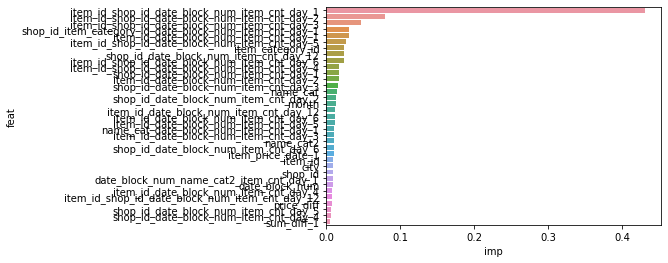

In [66]:
imp = pd.DataFrame({'imp': model.feature_importances_, 'feat': X_train.columns}).sort_values(by='imp', ascending=False)
sns.barplot(imp['imp'], imp['feat'])

In [67]:
# score 0.93473